# Image Processing with Python: Connected Components and Region Labeling

by: Jephraim C. Manansala | Published on https://jephraim-manansala.medium.com/

### How can we extract objects from an image and determine their properties?

In this post, we will explore how to automatically detect, label, and measure objects in images using connected components. This method addresses the shortcomings of blob detection methods by grouping pixels based on their connectivity.

Let’s begin.

As usual, we import libraries such as numpy and matplotlib. Additionally, we import specific functions from the skimage library.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table

What are **connected components**? Basically, it allows us to detect objects with irregular shapes and sizes based on the pixels’ connectivity to their neighbors. However, the use of connected components operations heavily relies on adequately cleaning the image using morphological operation.

Let’s try this on an image I took when I visited the *Pinto Art Museum in Rizal Province, Philippines*. Our goal will be to extract quantifiable features on each of the paintings on the image.

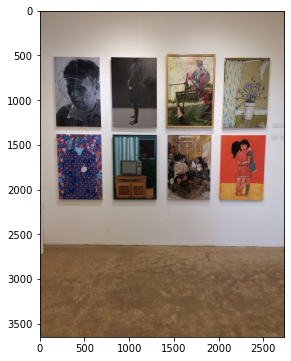

In [2]:
plt.figure(figsize=(6,6))
painting = imread('painting.jpg')
plt.imshow(painting);

If we apply the connected components algorithm on the raw image, this would almost immediately fail because of the various colors in the image. Thus, the first step would be to binarize the image using an arbitrary threshold value.

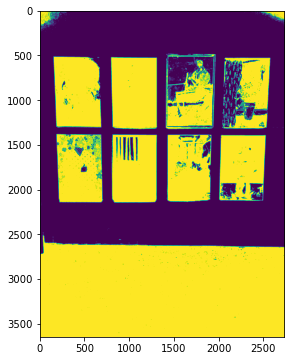

In [3]:
plt.figure(figsize=(6,6))

gray_painting = rgb2gray(painting)
binarized = gray_painting<0.55
plt.imshow(binarized);

We have set the arbitrary threshold value to maximize the shape of the frame of each painting. However, notice that the resulting image has several holes in the regions due to the light color used in the paintings. Let’s try to fix these using morphological operations.

In [4]:
square = np.array([[1,1,1],
                   [1,1,1],
                   [1,1,1]])

def multi_dil(im, num, element=square):
    for i in range(num):
        im = dilation(im, element)
    return im

def multi_ero(im, num, element=square):
    for i in range(num):
        im = erosion(im, element)
    return im

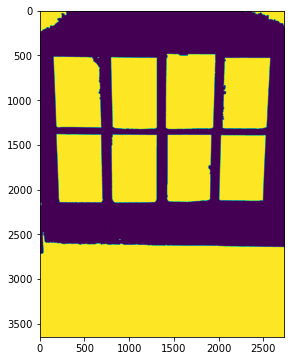

In [5]:
plt.figure(figsize=(6,6))
multi_dilated = multi_dil(binarized, 7)
area_closed = area_closing(multi_dilated, 50000)
multi_eroded = multi_ero(area_closed, 7)
opened = opening(multi_eroded)
plt.imshow(opened);

We have applied morphological operations such as successive `dilation` to close the pixels of the painting frame, `area_closing` to fill the holes inside the painting frame, successive `erosion` to restore the original shape of the objects, and finally, `opening` to remove the noise on the image. After applying these operations, the image is now ready for connected components operations!

The first function is `label` which labels the regions of the input image depending on the connectivity of the pixels to each other. As long as neighboring pixels share the same value, they will be labeled as a single region. This function will return a labeled array where all connected regions are assigned the same integer value.

After this, we can measure the properties of the regions in the labeled image by inputting the labeled array to the `regionprops` function. Several properties can be measured by this function, some of which are the area, *perimeter, major axis lengths, minor axis length*, and many more! Let’s try to use these functions.

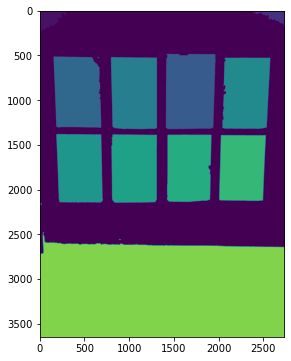

In [6]:
plt.figure(figsize=(6,6))
label_im = label(opened)
regions = regionprops(label_im)
plt.imshow(label_im);

The `label` function will label the regions from left to right, and from top to bottom. For this reason, region# 1 will be on the top-rightmost region in the image until all regions are assigned with an integer number. Each region’s color represents its integer region number and can be checked using the color bar on the side. Notice how there are 20+ regions on the image while the visible regions in the image are only about 10. This is because there is still noise present in the image and the noise is also considered as a region. Let’s try to filter these using the properties of each region.

Using the `regionprops_table` function, we can extract features and properties for each of the regions identified. In this example, we will be exploring the property features such as *area, convex_area, bbox_area, extent, mean_intensity, solidity, eccentricity, and orientation*. Each of these properties quantifies and explains the characteristics of each region compared to other regions. For example, the extent parameter measures the object’s fill area to its bounding box, while the *mean_intensity* measures the mean intensity value of the pixels in the region.

In [7]:
properties = ['area','convex_area','bbox_area', 'extent', 'mean_intensity',
              'solidity', 'eccentricity', 'orientation']
pd.DataFrame(regionprops_table(label_im, gray_painting, properties=properties))

,area,convex_area,bbox_area,extent,mean_intensity,solidity,eccentricity,orientation
0,44634,50384,80958,0.551323,0.547484,0.885876,0.796923,-1.042683
1,54,54,56,0.964286,0.556789,1.000000,0.487950,1.570796
2,31382,42283,76800,0.408620,0.545214,0.742190,0.938239,1.317563
3,174,214,299,0.581940,0.561545,0.813084,0.731981,1.435757
4,4,4,6,0.666667,0.412636,1.000000,0.790569,0.000000
5,446095,451617,465645,0.958015,0.449353,0.987773,0.760532,-0.042510
6,388494,394863,420812,0.923201,0.278782,0.983870,0.771639,0.104574
7,116,128,162,0.716049,0.546518,0.906250,0.871485,1.472895
8,398948,401120,410624,0.971565,0.252502,0.994585,0.775143,0.028141
9,390687,398336,424512,0.920320,0.490709,0.980798,0.779169,-0.069944


Notice how some regions’ area is almost negligible — these areas can be attributed to noise and can be filtered out using these properties.

We can also notice that region# 0 has one of the region’s most significant areas. However, region# 0 is always assigned by the label function for the background or the pixel intensities with 0. Thus, we should always filter out this region in our analysis.

Finally, notice how some regions have almost the same area covered while also almost being consecutive in the region numbering. This is because paintings are arranged in a lattice, and as mentioned earlier, the label function labels the regions from left to the right and then from top to bottom.

With these observations, we can filter our unnecessary regions in the image.

In [8]:
masks = []
bbox = []
list_of_index = []
for num, x in enumerate(regions):
    area = x.area
    convex_area = x.convex_area
    if (num!=0 and (area>100) and (convex_area/area <1.05)
    and (convex_area/area >0.95)):
        masks.append(regions[num].convex_image)
        bbox.append(regions[num].bbox)   
        list_of_index.append(num)
count = len(masks)

In filtering, we define an if-else statement to determine which regions will be used based on observed conditions — such as, regions that are NOT region# 0, regions with an area greater than 100, and regions with a `convex_area` to `area` ratio that is approximately equal to 1 *(to ensure that the object is indeed rectangular)*. From this, we can individually extract the desired regions from the image.

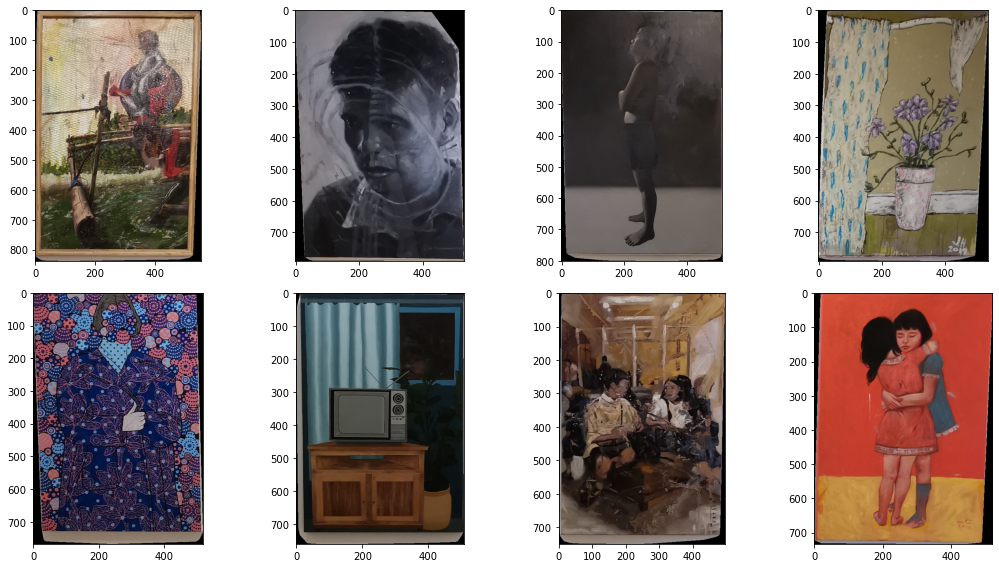

In [9]:
fig, ax = plt.subplots(2, int(count/2), figsize=(15,8))
for axis, box, mask in zip(ax.flatten(), bbox, masks):
    red  =  painting[:,:,0][box[0]:box[2], box[1]:box[3]] * mask
    green = painting[:,:,1][box[0]:box[2], box[1]:box[3]] * mask
    blue  = painting[:,:,2][box[0]:box[2], box[1]:box[3]] * mask
    image = np.dstack([red,green,blue])
    axis.imshow(image)
plt.tight_layout()

To extract the image within each region, we can use the bounding box attribute of `region_props` to determine each region’s exact coordinates in the image. From there, we would only need to slice the original image to get the image within each region.

We can also highlight the desired regions in the original image by creating a mask that hides unnecessary regions of the image. This can be done by combining the labeled array of the desired regions and using the combined mask on the original image.

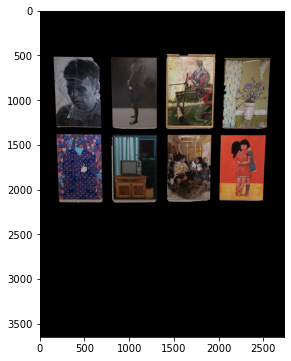

In [10]:
plt.figure(figsize=(6,6))

rgb_mask = np.zeros_like(label_im)
for x in list_of_index:
    rgb_mask += (label_im==x+1).astype(int)
red  =  painting[:,:,0] * rgb_mask
green = painting[:,:,1] * rgb_mask
blue  = painting[:,:,2] * rgb_mask
image = np.dstack([red,green,blue])
plt.imshow(image);

And that’s it! I hope you were able to realize the potential of `label`, `regionprops`, and `regionprops_table` function in the `skimage.measure` library. This can be a very powerful tool when conducting image processing projects in Python. Use it well!


#### In summary

We have explored how the connected components can extract features and information on each region of the image. This skillset can be particularly useful when getting creating machine learning algorithms from image datasets. Instead of employing a *blackbox approach*, we can opt for a more interpretable method by extracting quantifiable information from the image regions.